# Bibliotecas

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [ ]:
pip install catboost

     |████████████████████████████████| 67.4 MB 29 kB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_precision_recall_curve

# modelos
from sklearn import linear_model, ensemble
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree 
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC

# selecao modelos
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import brier_score_loss as brier
from sklearn.metrics import log_loss
from sklearn import metrics  
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import lime

In [ ]:
# configurando pasta do driver
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# config
pd.set_option('display.max_columns', None)
%matplotlib inline
#plt.rcParams['figure.figsize'] = [20, 14]

# Funções

In [ ]:
def plot_roc_curve(y_true, y_pred_proba):
  fpr, tpr, thresholds = metrics.roc_curve(y_true,  y_pred_proba)
  auc = metrics.roc_auc_score(y_true, y_pred_proba)

  roc = pd.DataFrame({
      'fpr' : fpr,
      'tpr' : tpr, 
      'tf' : tpr - (1-fpr),
      'thresholds' : thresholds
      })

  plt.plot(roc['fpr'],roc['tpr'],label="auc="+str(auc))
  plt.plot( [0,1], [0,1], '--r')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # optimal threshold
  point = roc.iloc[(roc.tf-0).abs().argsort()[0]]
  plt.scatter(
      point['fpr'], point['tpr'], color = 'purple', s = 50,
      label = f"optimal threshold  = {point['thresholds'].round(2)}"
      )

  # .5 threshold
  point = roc.iloc[(roc.thresholds-0.5).abs().argsort()[:1][0]]
  plt.scatter(
      point['fpr'], point['tpr'], color = 'orange', s = 50, 
      label = 'threshold = 0.50'
      )


  plt.legend()
  plt.show()

In [ ]:
def plot_models_roc_curve(models, X_test, y_test):
  plot_ax = metrics.plot_roc_curve(models[0], X_test, y_test)
  for i in range(1, len(models)):
    metrics.plot_roc_curve(models[i], X_test, y_test, ax=plot_ax.ax_)
  plt.show()

In [ ]:
# função que plota os n maiores coeficientes positivos e negativos
def plot_coefs(coefs, n):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  coefs.nsmallest(n, 'coef').query('coef < 0').sort_values('coef', ascending = False).plot(kind = 'barh', x = 'features', y = 'coef', color = 'red',  title = 'Coeficientes Negativos', legend=False, ax=ax1)
  coefs.nlargest(n, 'coef').query('coef >= 0').sort_values('coef', ascending = True).plot(kind = 'barh', x = 'features', y = 'coef', color = 'blue', title = 'Coeficientes Possitivos', legend=False, ax=ax2, xlabel = "")
  fig.tight_layout()

# Ler e processar dados

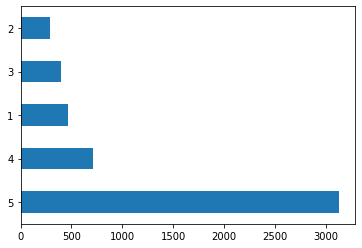

In [ ]:
# abrindo arquivo
data = pd.read_csv("/content/gdrive/MyDrive/SLIDES-IML/codigos/Reviews.csv"
  ,nrows=5e3
  )

y = data['Score'].copy()
X = data['Text'].copy()

# frequencia da variavel dependente
y.value_counts().plot(kind = 'barh')

In [ ]:
len(data)

5000

## Tratando os dados


*   Removendo números
*   Passando o texto para minúsculo
*   Dividindo em treino e teste
*   Transformando em matriz de contagens

In [ ]:
X.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [ ]:
# removendo numeros e passando para minusculo
X = (X
     .str.replace('[0-9]+', '', regex = True)
     .str.lower()
     )

X.head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price.  there was a wid...
Name: Text, dtype: object

In [ ]:
# dividindo em treino e teste
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 1/3, random_state = 0) 

In [ ]:
# transformando em matriz de contagens
cv = CountVectorizer(max_features = 1500, binary = True) 
# criando a partir dos dados de treino
X_train = cv.fit_transform(X_train)
# aplicando nos dados de teste
X_test = cv.transform(X_test)
# palabras utilizadas
features = cv.get_feature_names()
# formato
X_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
del data
del X
del y 

# Classificação Binária

In [ ]:
y_train=(Y_train>3).astype(int)
y_test=(Y_test>3).astype(int)

resultados = pd.DataFrame(columns = ['Method','Acurácia','F1','Log-loss'])

In [ ]:
X_train_dense = X_train.todense()
X_test_dense  = X_test.todense()

In [ ]:
X_train_df = pd.DataFrame(X_train_dense, columns = features)
X_test_df = pd.DataFrame(X_test_dense, columns = features)

In [ ]:
from sklearn.utils import class_weight
classes_weights = list(class_weight.compute_class_weight(
    'balanced', 
    np.unique(y_train), y_train
    )
  )

weights = [classes_weights[i] for i in y_train]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=3276    1
3688    1
2204    1
572     1
229     0
       ..
4931    1
3264    1
1653    1
2607    1
2732    0
Name: Score, Length: 3333, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


## Exemplo: Classes desbalanceadas

In [ ]:
y_train.value_counts(normalize = True)*100

1    76.957696
0    23.042304
Name: Score, dtype: float64

Acurácia = 0.8386322735452909
F1 = 0.8990619136960601


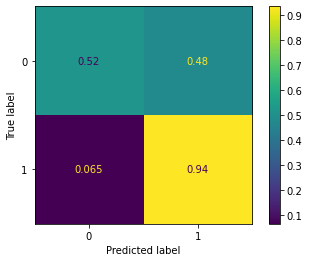

In [ ]:
logistica_l1 = linear_model.LogisticRegressionCV(
    penalty="l1",solver='liblinear',scoring='neg_log_loss', max_iter=100
    ).fit(X=X_train,y=y_train)
# plot confunsion matriz
y_pred = logistica_l1.predict(X_test)
print(f"Acurácia = {acc(y_test,y_pred)}")
print(f"F1 = {metrics.f1_score(y_test, y_pred)}")
metrics.plot_confusion_matrix(logistica_l1, X_test, y_test, normalize = 'true')

Acurácia = 0.8026394721055788
F1 = 0.8651086510865109


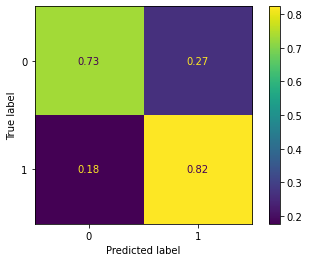

In [ ]:
logistica_l1 = linear_model.LogisticRegressionCV(
    penalty="l1",solver='liblinear',scoring='neg_log_loss', max_iter=100, 
    class_weight = 'balanced'
    ).fit(X=X_train,y=y_train)
# plot confunsion matriz
y_pred = logistica_l1.predict(X_test)
print(f"Acurácia = {acc(y_test,y_pred)}")
print(f"F1 = {metrics.f1_score(y_test, y_pred)}")
metrics.plot_confusion_matrix(logistica_l1, X_test, y_test, normalize = 'true')

## Logística

### Sem Penalização

In [ ]:
logistica = linear_model.LogisticRegression(
    penalty = "none", max_iter=1000
    ).fit(X = X_train,y = y_train)
# 31s

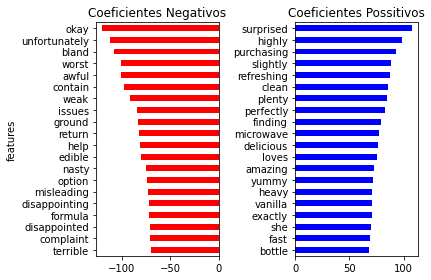

In [ ]:
# plotando maiores coeficientes
plot_coefs(
    coefs = pd.DataFrame({
        'features':features, 
        'coef':logistica.coef_[0]
        }), 
    n = 20
    )

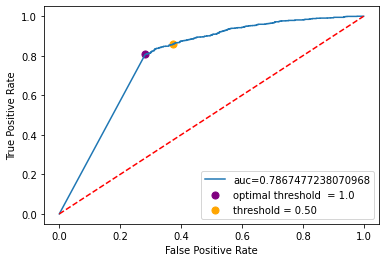

In [ ]:
# ROC curve
plot_roc_curve(y_test, logistica.predict_proba(X_test)[:,1])

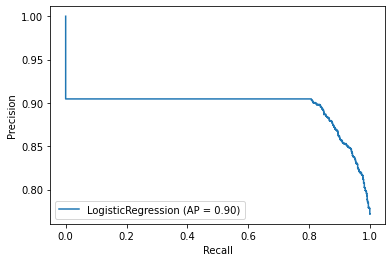

In [ ]:
plot_precision_recall_curve(logistica, X_test, y_test)

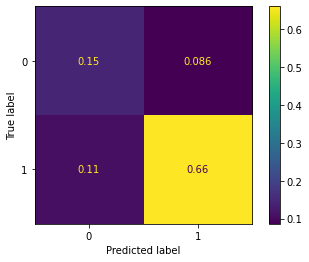

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(logistica, X_test, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = logistica.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['Logística'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

      Method  Acurácia       F1  Log-loss
0  Logística  0.804439  0.87084  5.829505


### Com penalização

In [ ]:
logistica_l1 = linear_model.LogisticRegressionCV(
    penalty="l1",solver='liblinear',scoring='neg_log_loss', 
    max_iter=100, cv = 10
    ).fit(X=X_train,y=y_train)

In [ ]:
print(f"total de variaveis com coeficientes 0 = {sum(logistica_l1.coef_[0]==0)}")
print(f"total de variaveis = {len(logistica_l1.coef_[0])}")

total de variaveis com coeficientes 0 = 1153
total de variaveis = 1500


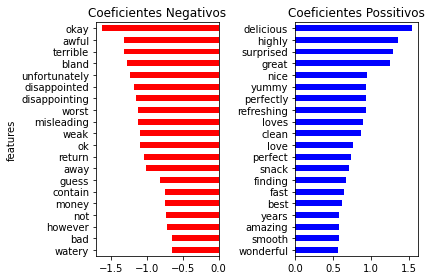

In [ ]:
# plotando maiores coeficientes
plot_coefs(
    coefs = pd.DataFrame({
        'features':features, 
        'coef':logistica_l1.coef_[0]
        }), 
    n = 20
    )

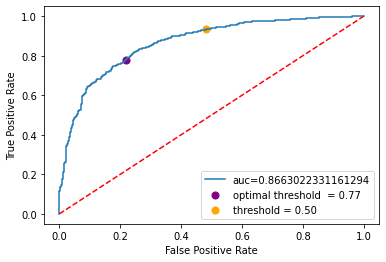

In [ ]:
# ROC curve
plot_roc_curve(y_test, logistica_l1.predict_proba(X_test)[:,1])

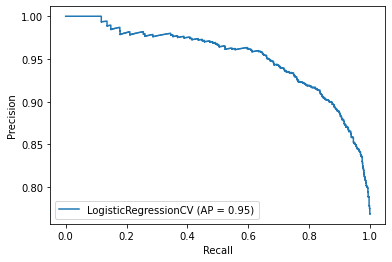

In [ ]:
plot_precision_recall_curve(logistica_l1, X_test, y_test)

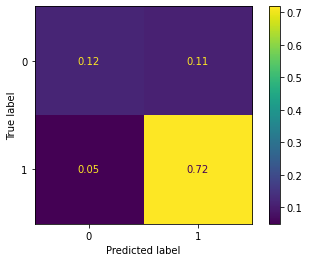

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(logistica_l1, X_test, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = logistica_l1.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['Logística L1'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

         Method  Acurácia        F1  Log-loss
0     Logística  0.804439  0.870840  5.829505
0  Logística L1  0.838632  0.899062  0.369243


### Comparação

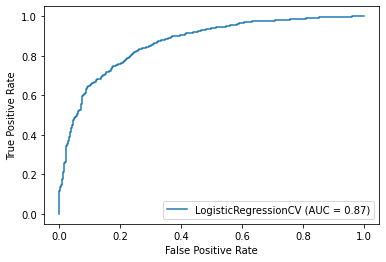

In [ ]:
metrics.plot_roc_curve(logistica_l1, X_test, y_test)

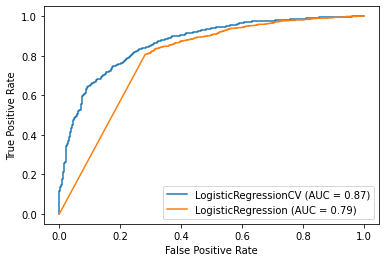

In [ ]:
plot_models_roc_curve(
    models = [logistica_l1, logistica], 
    X_test = X_test, y_test = y_test
    )

## Árvores de Decisão

Melhores Parametros: {'max_depth': 4}


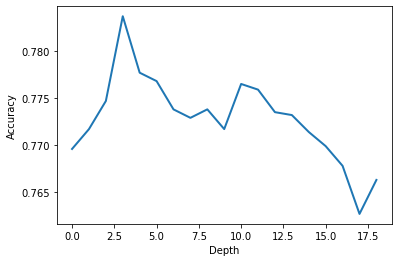

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
arvore = DecisionTreeClassifier(random_state = 0)

# otimização de hiperparametros
param_grid = {'max_depth':np.arange(1, 20)}
arvore_gscv = GridSearchCV(arvore, param_grid, cv = 10, scoring='accuracy')
arvore_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {arvore_gscv.best_params_}")

plt.figure()
plt.plot(arvore_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

# utilizando o melhores parametros
arvore.set_params(**arvore_gscv.best_params_)
arvore.fit(X_train,y_train)

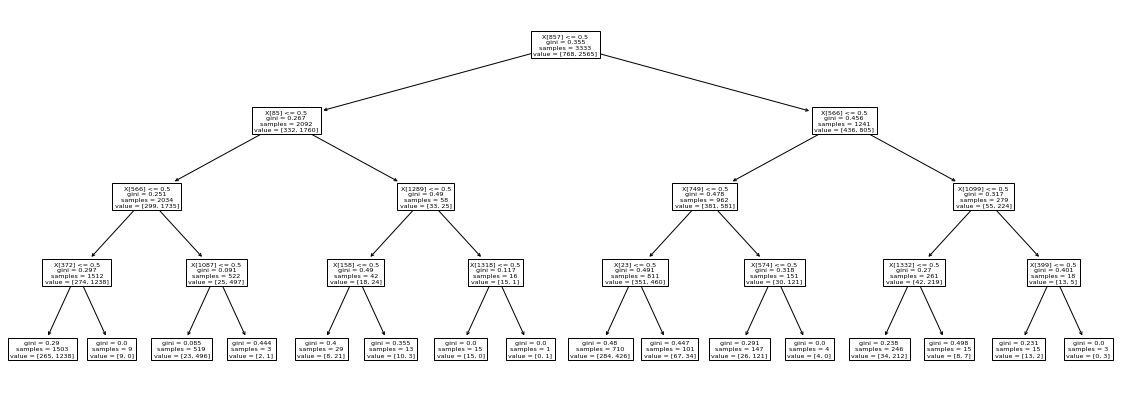

In [ ]:
# plotando arvore de decisão
plt.rcParams['figure.figsize'] = [20, 7]
plot_tree(arvore)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

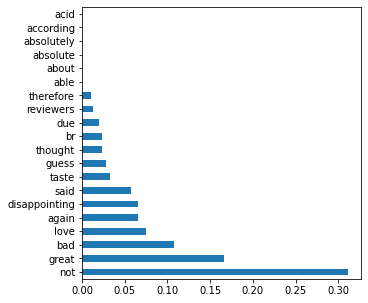

In [ ]:
# plotando as variaveis mais importantes
feat_importances = pd.Series(
    arvore.feature_importances_, 
    index= features)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

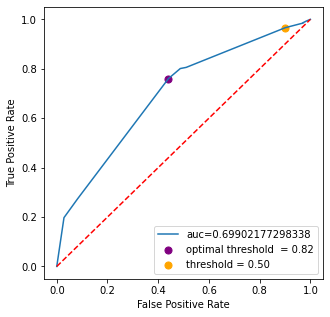

In [ ]:
# ROC curve
plot_roc_curve(y_test, arvore.predict_proba(X_test)[:,1])

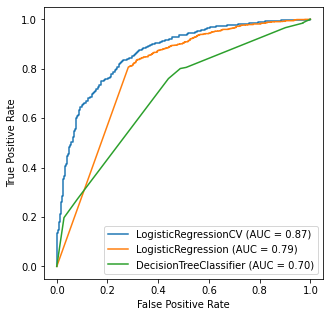

In [ ]:
plot_models_roc_curve(
    models = [logistica_l1, logistica, arvore], 
    X_test = X_test_dense, y_test = y_test
    )

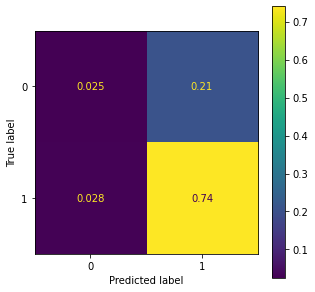

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(arvore, X_test, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = arvore.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['Árvore de Decisão'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558


## Florestas

Melhores Parametros: {'max_depth': 60, 'max_features': 'auto'}


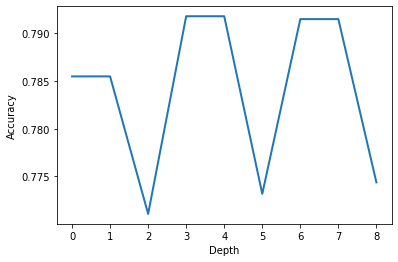

RandomForestClassifier(max_depth=60, n_estimators=400, random_state=0)

In [ ]:
floresta = RandomForestClassifier(random_state = 0, n_estimators = 400)

# otimização de hiperparametros
param_grid = {
    'max_depth': [30, 60, 90],
    'max_features': ['auto', 'sqrt', 'log2']
    }
floresta_gscv = GridSearchCV(floresta, param_grid, cv=2,scoring='accuracy')
floresta_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {floresta_gscv.best_params_}")

plt.figure()
plt.plot(floresta_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

# utilizando o melhores parametros
floresta.set_params(**floresta_gscv.best_params_)
floresta.fit(X_train,y_train)

In [ ]:
floresta = RandomForestClassifier(random_state = 0, n_estimators = 400)
best = {'max_depth': 60, 'max_features': 'auto'}
floresta.set_params(**best)
floresta.fit(X_train,y_train)

RandomForestClassifier(max_depth=60, n_estimators=400, random_state=0)

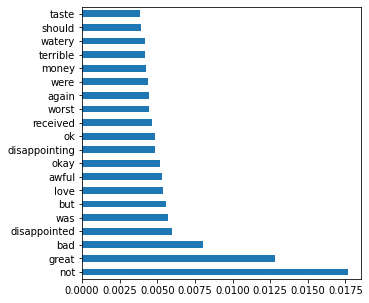

In [ ]:
# plotando as variaveis mais importantes
feat_importances = pd.Series(
    floresta.feature_importances_, 
    index= features)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

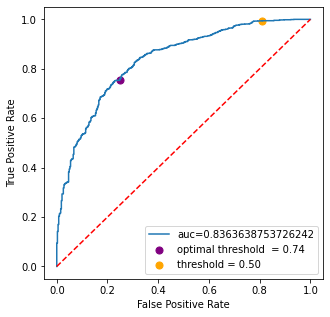

In [ ]:
# ROC curve
plot_roc_curve(y_test, floresta.predict_proba(X_test)[:,1])

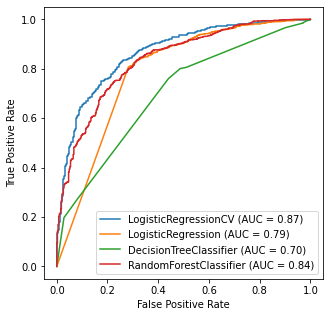

In [ ]:
# comparando a curva ROC
plot_models_roc_curve(
    models = [logistica_l1, logistica, arvore, floresta], 
    X_test = X_test_dense, y_test = y_test
    )

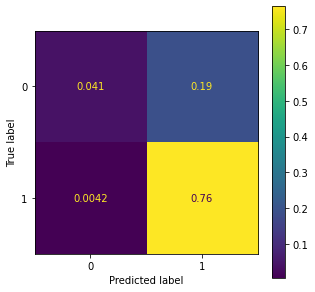

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(floresta, X_test, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = floresta.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['Florestas'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558
0          Florestas  0.805639  0.887187  0.418737


In [ ]:
resultados = pd.DataFrame( 
    [['Logística'  0.874843  0.920521  0.314627], 
    ['Logística' L1  0.877152  0.922445  0.296219],
    ['Árvore de Decisão'  0.808784  0.882046  1.591426],
    ['Florestas'  0.852253  0.912021  0.334034]],
    columns = ['Method', 'Acurácia', 'F1', 'Log-loss'])

SyntaxError: ignored

## XGBoost

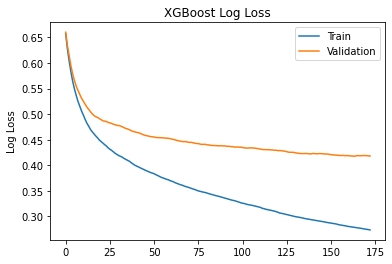

In [ ]:
xgb_model = xgb.XGBClassifier()

# otimização de hiperparametro
parameters = {'max_depth': [3,7,15,30],
              'min_child_weight': [2,5],
              'subsample': [0.8,1],
              'colsample_bytree': [0.75,1],
              'n_estimators': [350, 500], 
              'eta':[0.5,1]}

X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=7)
eval_set = [(X_train_1,y_train_1),(X_val, y_val)]

xgb_model_gscv = GridSearchCV(xgb_model, parameters, n_jobs=4, cv=2,scoring='neg_brier_score')
xgb_model_gscv.fit(
    X_train_1, y_train_1,
    eval_set=eval_set,eval_metric=["error", "logloss"],verbose=0, 
    early_stopping_rounds=10,sample_weight=weights
    )

xgb_model_gscv.best_params_

results = xgb_model_gscv.best_estimator_.evals_result()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot 
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

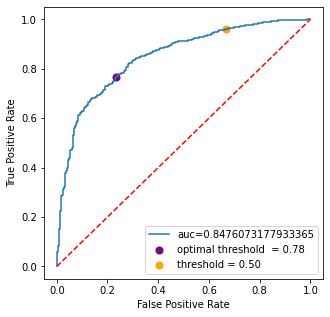

In [ ]:
# ROC curve
plot_roc_curve(y_test, xgb_model_gscv.predict_proba(X_test)[:,1])

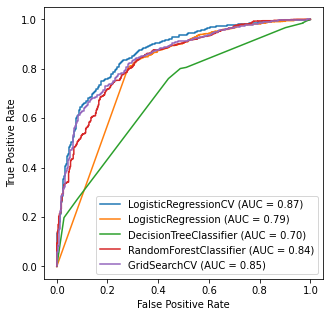

In [ ]:
# comparando a curva ROC
plot_models_roc_curve(
    models = [logistica_l1, logistica, arvore, floresta, xgb_model_gscv], 
    X_test = X_test, y_test = y_test
    )

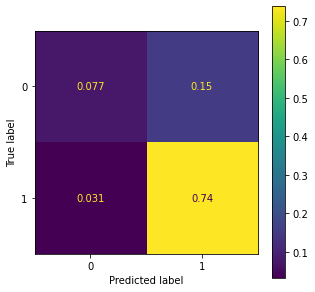

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(xgb_model_gscv, X_test, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultadoX_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=7)

y_prob = xgb_model_gscv.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['XGBoost'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558
0          Florestas  0.805639  0.887187  0.418737
0            XGBoost  0.814637  0.888327  0.395084


## LightGBM

In [ ]:
lgb_model = lgb.LGBMClassifier()

# otimização de hiperparametros
params_grid = {'learning_rate': [0.01], 'n_estimators': [8, 24],
                'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                'objective': ['binary'],
                'colsample_bytree': [0.65, 0.75, 0.8], 
                'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                'reg_lambda': [1, 2, 6]}

lgb_rscv = GridSearchCV(lgb_model, params_grid, cv=2,scoring='neg_log_loss')
lgb_rscv.fit(X_train_dense, y_train,sample_weight=weights)

# resultado
print(f"Melhor Pontuação: {lgb_rscv.best_score_}")
print(f"Melhores Parametros: {lgb_rscv.best_params_}")

# utilizando o melhores parametros
lgb_model.set_params(**lgb_rscv.best_params_)
lgb_model.fit(X_train_dense,y_train)

Melhor Pontuação: -0.6630166845070614
Melhores Parametros: {'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.01, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=24, n_jobs=-1, num_leaves=16, objective='binary',
               random_state=None, reg_alpha=1, reg_lambda=1, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

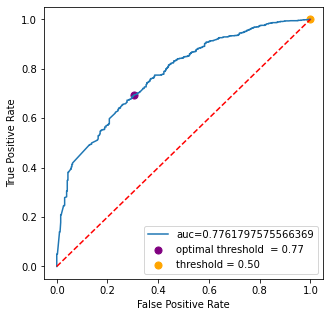

In [ ]:
# ROC curve
plot_roc_curve(y_test, lgb_model.predict_proba(X_test_dense)[:,1])

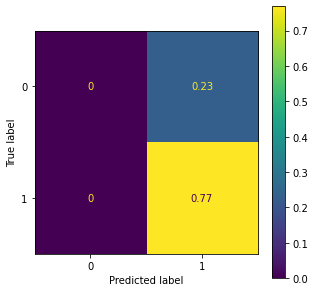

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(lgb_model, X_test_dense, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultadoX_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=7)

y_prob = lgb_model.predict_proba(X_test_dense)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['LightGBM'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558
0          Florestas  0.805639  0.887187  0.418737
0            XGBoost  0.814637  0.888327  0.395084
0           LightGBM  0.768446  0.869064  0.516580


## CatBoost

In [ ]:
catb = CatBoostClassifier()

# otimização de hiperparametros
params_grid = [{
    'depth':[3,1,2,6,4,5,7,8,9,10],
    'iterations':[250,100,500,1000],
    'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
    'l2_leaf_reg':[3,1,5,10,100],
    'border_count':[32,5,10,20,50,100,200],
    #'ctr_border_count':[50,5,10,20,100,200],
    'thread_count':[4]
    }]
catb_rscv = RandomizedSearchCV(catb, params_grid, cv=2,scoring='accuracy', n_iter = 15)
catb_rscv.fit(X_train_df, y_train, sample_weight=weights)

# resultado
print(f"Melhor Pontuação: {catb_rscv.best_params_}")
print(f"Melhores Parametros: {catb_rscv.best_params_}")

# utilizando o melhores parametros
catb.set_params(**catb_rscv.best_params_)
catb.fit(X_train_df,y_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
202:	learn: 0.5578351	total: 2.62s	remaining: 607ms
203:	learn: 0.5575064	total: 2.63s	remaining: 594ms
204:	learn: 0.5571551	total: 2.65s	remaining: 581ms
205:	learn: 0.5566378	total: 2.66s	remaining: 568ms
206:	learn: 0.5560042	total: 2.67s	remaining: 554ms
207:	learn: 0.5556768	total: 2.68s	remaining: 541ms
208:	learn: 0.5553083	total: 2.7s	remaining: 530ms
209:	learn: 0.5548472	total: 2.71s	remaining: 517ms
210:	learn: 0.5545127	total: 2.73s	remaining: 504ms
211:	learn: 0.5541152	total: 2.74s	remaining: 491ms
212:	learn: 0.5537453	total: 2.75s	remaining: 478ms
213:	learn: 0.5533892	total: 2.76s	remaining: 464ms
214:	learn: 0.5530176	total: 2.77s	remaining: 451ms
215:	learn: 0.5525917	total: 2.79s	remaining: 440ms
216:	learn: 0.5522232	total: 2.81s	remaining: 427ms
217:	learn: 0.5517692	total: 2.83s	remaining: 415ms
218:	learn: 0.5513909	total: 2.84s	remaining: 402ms
219:	learn: 0.5510753	total: 2.85s	remaining: 389ms
220:	l

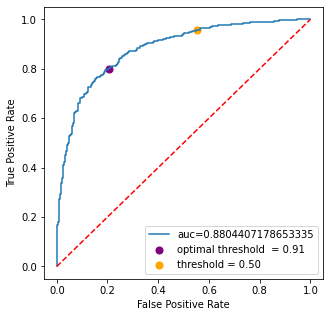

In [ ]:
# ROC curve
plot_roc_curve(y_test, catb.predict_proba(X_test_df)[:,1])

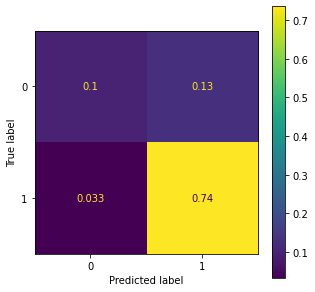

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(catb, X_test_df, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = catb.predict_proba(X_test_df)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['CatBoost'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558
0          Florestas  0.805639  0.887187  0.418737
0            XGBoost  0.814637  0.888327  0.395084
0           LightGBM  0.768446  0.869064  0.516580
0           CatBoost  0.839232  0.901471  0.414609


## KNN

### Com todas variáveis

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Melhores Parametros: {'n_neighbors': 19}


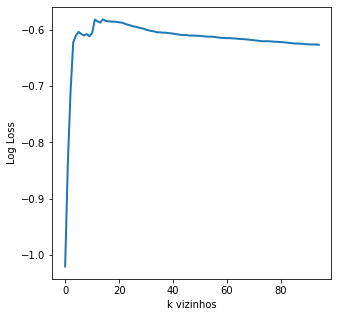

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [ ]:
# criando modelo
knn = KNeighborsClassifier()

# otimização de hiperparametros
param_grid = {'n_neighbors': np.arange(5, 100)}
knn_gscv = GridSearchCV(knn, param_grid, cv=2,scoring='neg_log_loss')
knn_gscv.fit(X_train_resampled, y_train_resampled)

# resultado
# resultado
print(f"Melhores Parametros: {knn_gscv.best_params_}")

plt.figure()
plt.plot(knn_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('k vizinhos')
plt.ylabel('Log Loss')
plt.show()

# utilizando o melhores parametros
knn.set_params(**knn_gscv.best_params_)
knn.fit(X_train,y_train)

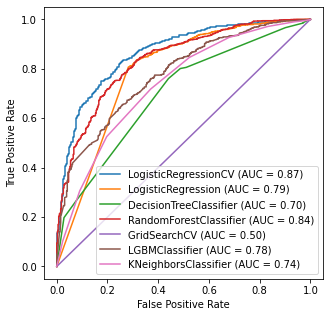

In [ ]:
# ROC curve
plot_models_roc_curve(
    models = [logistica_l1, logistica, arvore, floresta, xgb_model_gscv, lgb_model, knn], 
    X_test = X_test_dense, y_test = y_test
    )

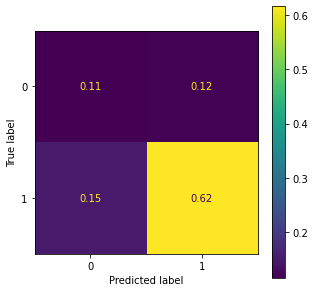

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(knn_gscv, X_test, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = knn_gscv.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['KNN'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558
0          Florestas  0.805639  0.887187  0.418737
0            XGBoost  0.814637  0.888327  0.395084
0           LightGBM  0.768446  0.869064  0.516580
0           CatBoost  0.839232  0.901471  0.414609
0                KNN  0.731254  0.821086  0.681436


### Com seleção de variáveis

In [ ]:
from sklearn.feature_selection import RFECV
floresta_rfe = RFECV(
    floresta, min_features_to_select = 50, 
    step = 0.3, verbose = 10, cv=2
    ).fit(X_train,y_train)

Fitting estimator with 1500 features.
Fitting estimator with 1050 features.
Fitting estimator with 600 features.
Fitting estimator with 150 features.
Fitting estimator with 1500 features.
Fitting estimator with 1050 features.
Fitting estimator with 600 features.
Fitting estimator with 150 features.
Fitting estimator with 1500 features.
Fitting estimator with 1050 features.
Fitting estimator with 600 features.


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train[:,floresta_rfe.support_], y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Melhores Parametros: {'n_neighbors': 17}


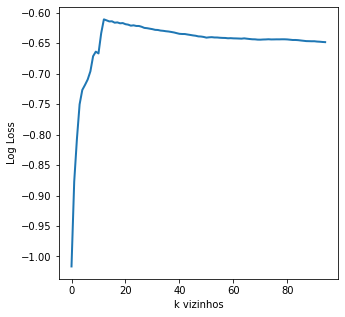

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [ ]:
# criando modelo
knn_rfe = KNeighborsClassifier()

# otimização de hiperparametros
param_grid = {'n_neighbors': np.arange(5, 100)}
knn_gscv = GridSearchCV(knn_rfe, param_grid, cv=2,scoring='neg_log_loss')
knn_gscv.fit(X_train_resampled, y_train_resampled)

# resultado
# resultado
print(f"Melhores Parametros: {knn_gscv.best_params_}")

plt.figure()
plt.plot(knn_gscv.cv_results_['mean_test_score'],linewidth=2)
plt.xlabel('k vizinhos')
plt.ylabel('Log Loss')
plt.show()

# utilizando o melhores parametros
knn_rfe.set_params(**knn_gscv.best_params_)
knn_rfe.fit(X_train[:,linear_rfe.support_],y_train)

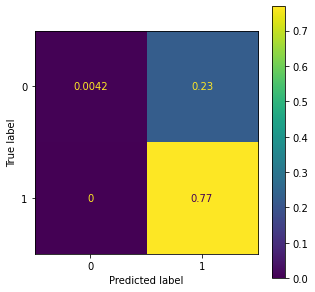

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(knn_rfe, X_test[:,linear_rfe.support_], y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = knn_rfe.predict_proba(X_test[:,linear_rfe.support_])[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['KNN RFE'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

              Method  Acurácia        F1  Log-loss
0          Logística  0.804439  0.870840  5.829505
0       Logística L1  0.838632  0.899062  0.369243
0  Árvore de Decisão  0.764847  0.862937  0.694558
0          Florestas  0.805639  0.887187  0.418737
0            XGBoost  0.814637  0.888327  0.395084
0           LightGBM  0.768446  0.869064  0.516580
0           CatBoost  0.839232  0.901471  0.414609
0                KNN  0.731254  0.821086  0.681436
0            KNN RFE  0.772645  0.871132  1.055317


## Naive Bayes

In [ ]:
nb = CategoricalNB().fit(X_train_dense, y_train)

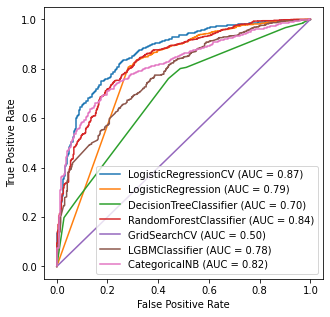

In [ ]:
plot_models_roc_curve(
    models = [logistica_l1, logistica, arvore, floresta, xgb_model_gscv, lgb_model, nb], 
    X_test = X_test_dense, y_test = y_test
    )

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = nb.predict_proba(X_test_dense)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['Categorical Naive Bayes'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

                    Method  Acurácia        F1  Log-loss
0                Logística  0.804439  0.870840  5.829505
0             Logística L1  0.838632  0.899062  0.369243
0        Árvore de Decisão  0.764847  0.862937  0.694558
0                Florestas  0.805639  0.887187  0.418737
0                  XGBoost  0.814637  0.888327  0.395084
0                 LightGBM  0.768446  0.869064  0.516580
0                 CatBoost  0.839232  0.901471  0.414609
0                      KNN  0.731254  0.821086  0.681436
0                  KNN RFE  0.772645  0.871132  1.055317
0  Categorical Naive Bayes  0.773845  0.851750  1.103207


## SVM

In [ ]:
svc = SVC(random_state = 0, probability=True, class_weight = 'balanced')

# otimização de hiperparametros
param_grid = [{'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly', 'sigmoid']}]
svc_gscv = GridSearchCV(svc, param_grid, cv=2,scoring='accuracy')
svc_gscv.fit(X_train, y_train)

# resultado
print(f"Melhores Parametros: {svc_gscv.best_params_}")

# utilizando o melhores parametros
svc.set_params(**svc_gscv.best_params_)
svc.fit(X_train,y_train)

Melhores Parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
svc = SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

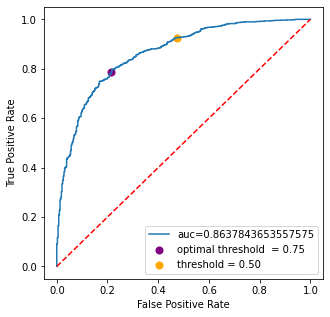

In [ ]:
# ROC curve
plot_roc_curve(y_test, svc.predict_proba(X_test)[:,1])

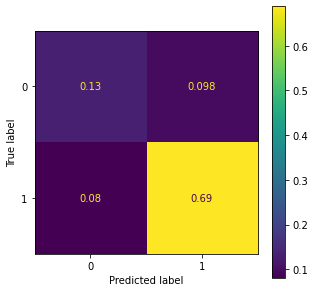

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(svc, X_test, y_test, normalize = 'true')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = svc.predict_proba(X_test)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['SVM'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

                    Method  Acurácia        F1  Log-loss
0                Logística  0.804439  0.870840  5.829505
0             Logística L1  0.838632  0.899062  0.369243
0        Árvore de Decisão  0.764847  0.862937  0.694558
0                Florestas  0.805639  0.887187  0.418737
0                  XGBoost  0.814637  0.888327  0.395084
0                 LightGBM  0.768446  0.869064  0.516580
0                 CatBoost  0.839232  0.901471  0.414609
0                      KNN  0.731254  0.821086  0.681436
0                  KNN RFE  0.772645  0.871132  1.055317
0  Categorical Naive Bayes  0.773845  0.851750  1.103207
0                      SVM  0.833833  0.895274  0.368724


## Nnets

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                45030     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 45,761
Trainable params: 45,761
Non-trainable params: 0
____________________________________________________

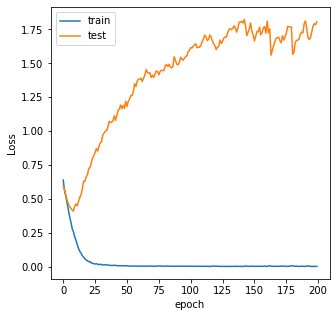

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=X_train_dense.shape[1]),
        layers.Dense(30, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(5, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

batch_size = 200
epochs = 200

metrics_score = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(loss="binary_crossentropy", optimizer="adam",metrics = metrics_score)

history = model.fit(
    X_train_dense, y_train, 
    batch_size=batch_size, epochs=epochs, 
    validation_split=0.1,shuffle=True,verbose=0)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

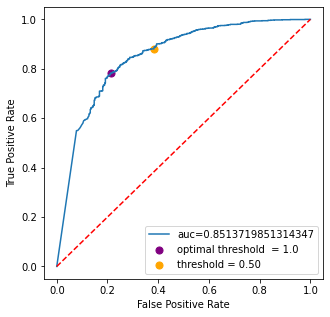

In [ ]:
# ROC curve
plot_roc_curve(y_test, model.predict(X_test_dense))

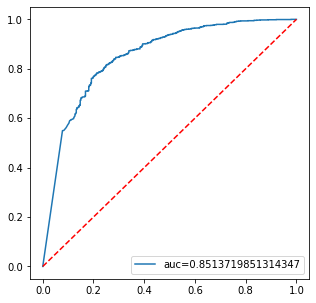

In [ ]:
# plot confunsion matriz
y_pred_proba = model.predict(X_test_dense)
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.plot( [0,1], [0,1], '--r')
plt.show()

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = model.predict(X_test)
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob.astype(np.float64))
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['Nnets'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

                    Method  Acurácia        F1  Log-loss
0                Logística  0.804439  0.870840  5.829505
0             Logística L1  0.838632  0.899062  0.369243
0        Árvore de Decisão  0.764847  0.862937  0.694558
0                Florestas  0.805639  0.887187  0.418737
0                  XGBoost  0.814637  0.888327  0.395084
0                 LightGBM  0.768446  0.869064  0.516580
0                 CatBoost  0.839232  0.901471  0.414609
0                      KNN  0.731254  0.821086  0.681436
0                  KNN RFE  0.772645  0.871132  1.055317
0  Categorical Naive Bayes  0.773845  0.851750  1.103207
0                      SVM  0.833833  0.895274  0.368724
0                    Nnets  0.821836  0.884030  1.847781


## VotingClassifier

In [ ]:
evc = ensemble.VotingClassifier(estimators=[
          ('florestas', floresta), 
          ('logistica', logistica_l1), 
          ('naiveBayes', nb), 
          ('SVM', svc), 
          ('knn', knn_rfe)
          ], voting='soft'
        )
evc.fit(X_train_dense,y_train)

VotingClassifier(estimators=[('florestas',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=60,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
   

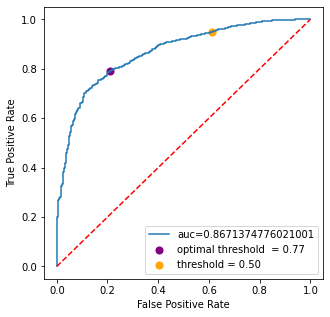

In [ ]:
# ROC curve
plot_roc_curve(y_test, evc.predict_proba(X_test_dense)[:,1])

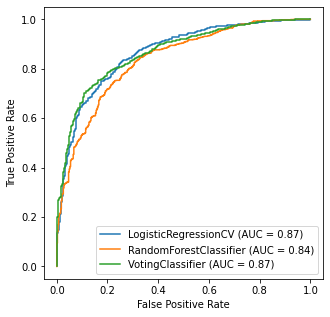

In [ ]:
# comparando a curva ROC
plot_models_roc_curve(
    models = [logistica_l1, floresta, evc], 
    X_test = X_test_dense, y_test = y_test
    )

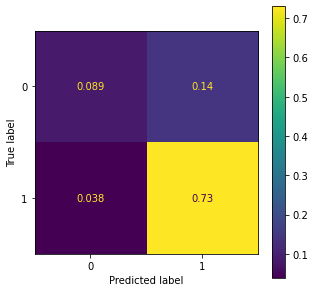

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(evc, X_test_dense, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = evc.predict_proba(X_test_dense)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['VotingClassifier'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

                    Method  Acurácia        F1  Log-loss
0                Logística  0.804439  0.870840  5.829505
0             Logística L1  0.838632  0.899062  0.369243
0        Árvore de Decisão  0.764847  0.862937  0.694558
0                Florestas  0.805639  0.887187  0.418737
0                  XGBoost  0.814637  0.888327  0.395084
0                 LightGBM  0.768446  0.869064  0.516580
0                 CatBoost  0.839232  0.901471  0.414609
0                      KNN  0.731254  0.821086  0.681436
0                  KNN RFE  0.772645  0.871132  1.055317
0  Categorical Naive Bayes  0.773845  0.851750  1.103207
0                      SVM  0.833833  0.895274  0.368724
0                    Nnets  0.821836  0.884030  1.847781
0         VotingClassifier  0.819436  0.889945  0.377178


## StackingClassifier

In [ ]:
esc = ensemble.StackingClassifier(estimators=[
          ('florestas', floresta), 
          ('logistica', logistica_l1), 
          ('naiveBayes', nb), 
          ('SVM', svc), 
          ('XGBoost', xgb_model_gscv)
          ]
        )
esc.fit(X_train_dense,y_train)

KeyboardInterrupt: ignored

In [ ]:
# ROC curve
plot_roc_curve(y_test, esc.predict_proba(X_test_dense)[:,1])

In [ ]:
# comparando a curva ROC
plot_models_roc_curve(
    models = [logistica_l1, floresta, evc, esc], 
    X_test = X_test_dense, y_test = y_test
    )

In [ ]:
# plot confunsion matriz
metrics.plot_confusion_matrix(esc, X_test_dense, y_test, normalize = 'all')

In [ ]:
#limiar
lim = .5
# salvando resultado
y_prob = esc.predict_proba(X_test_dense)[:,1]
y_pred = (y_prob > lim)*1
acc_estimate = acc(y_test,y_pred)
log_estimate = log_loss(y_test,y_prob)
f1_score = metrics.f1_score(y_test, y_pred)
resultados = resultados.append(pd.DataFrame({
    'Method': ['StackingClassifier'],
    'Acurácia': [acc_estimate],
    'F1': [f1_score],
    'Log-loss': [log_estimate]
  }))
print(resultados)

## Resultados

In [ ]:
resultados

# Interpretação

## PDP

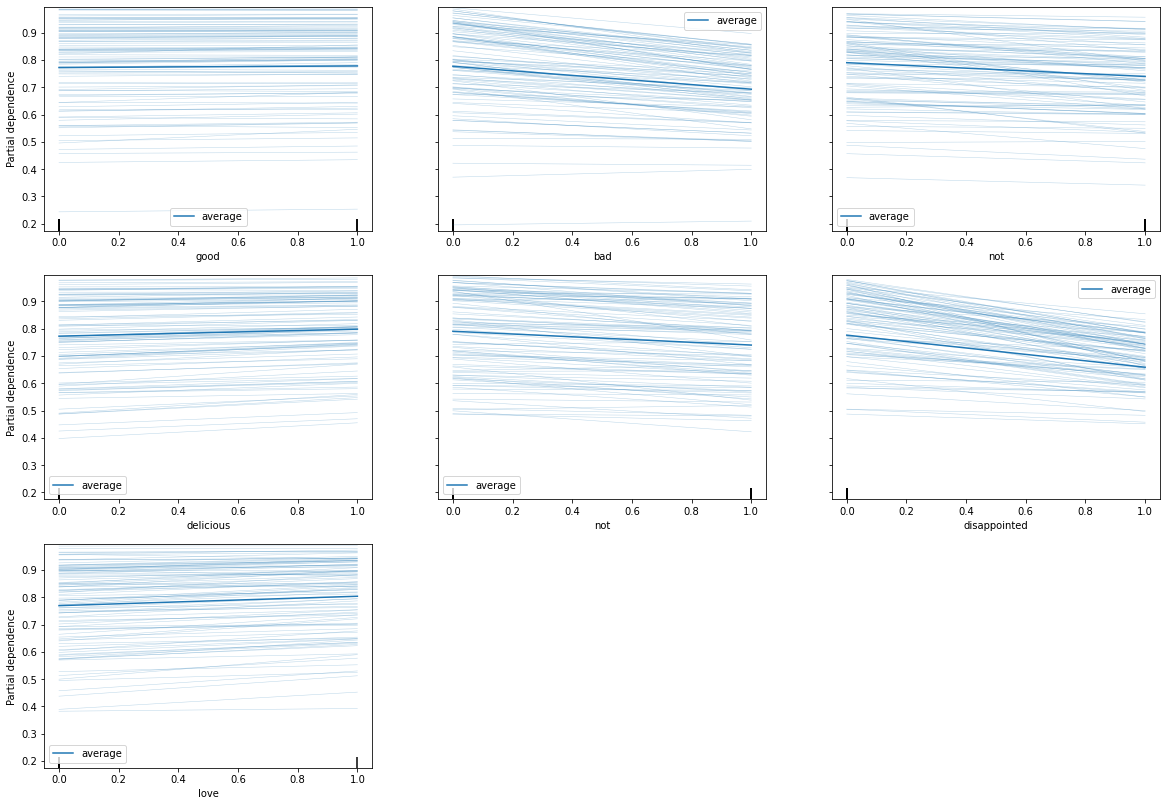

In [ ]:
plt.rcParams['figure.figsize'] = [20, 14]
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(
    floresta, 
    pd.DataFrame(X_test_dense, columns = features), 
    kind = 'both', subsample=100, 
    n_jobs=3, grid_resolution=20, 
    features=['good','bad','not', 'delicious', 'not', 'disappointed', 'love']
    )
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

## LIME

In [ ]:
import lime.lime_tabular as lime_tabular
predict_ = lambda x: logistica_l1.predict_proba(x).astype(float)
explainer = lime_tabular.LimeTabularExplainer(
    X_train, mode="classification",
    feature_names = features,
    class_names=['Score Baixo','Score Alto']
    )

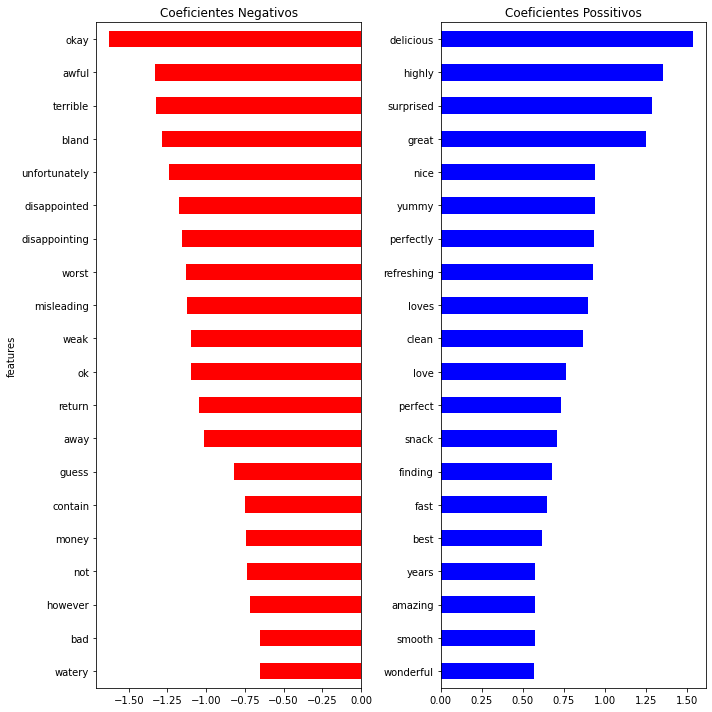

In [ ]:
# plotando maiores coeficientes
plot_coefs(
    coefs = pd.DataFrame({
        'features':features, 
        'coef':logistica_l1.coef_[0]
        }), 
    n = 20
    )

In [ ]:
choosen_instance = pd.DataFrame(X_test_dense).loc[[126]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_,  num_features=10)
exp.show_in_notebook(show_all=False)